**Imports**

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, matthews_corrcoef, roc_curve, auc
from prettytable import PrettyTable
from IPython.display import HTML
from keras import metrics

import pickle

**Validation and test data loading**


In [2]:
!cp '/content/drive/MyDrive/VU Amsterdam/Year 3/Machine Learning/MLProject/src/data.zip' . 
!unzip data.zip > /dev/null

dir = 'data/'
df = pd.read_csv(dir + 'labels.csv')
df['path'] = df['path'].str.replace('\\', os.sep)

valid_df =df.loc[df['is_validation'] == 1]
test_df = df.loc[df['is_final_validation'] == 1 ]

valid_cleaned_df = pd.concat( [valid_df.loc[valid_df['is_bee'] == 1], valid_df.loc[valid_df['is_wasp'] == 1] ])
test_cleaned_df = pd.concat( [test_df.loc[test_df['is_bee'] == 1], test_df.loc[test_df['is_wasp'] == 1] ])

gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

valid = gen.flow_from_dataframe(valid_cleaned_df, directory= 'data/', x_col='path', y_col='label', target_size=(256,256), class_mode="binary", shuffle=False)
test = gen.flow_from_dataframe(test_cleaned_df, directory= 'data/', x_col='path', y_col='label', target_size=(256,256), class_mode="binary", shuffle=False)

Found 1234 validated image filenames belonging to 2 classes.
Found 1257 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


**Import the saved model into the local file system**

In [3]:
!cp '/content/drive/Shareddrives/ML_Group129/src/ANN/HyperTuner Results Hyperband ANN/hp_ann_model.zip' .
!unzip hp_ann_model.zip

Archive:  hp_ann_model.zip
   creating: hp_ann_model/
   creating: hp_ann_model/assets/
  inflating: hp_ann_model/saved_model.pb  
   creating: hp_ann_model/variables/
  inflating: hp_ann_model/variables/variables.index  
  inflating: hp_ann_model/variables/variables.data-00000-of-00001  
  inflating: hp_ann_model/keras_metadata.pb  


In [4]:
!cp '/content/drive/Shareddrives/ML_Group129/src/CNN/HyperTuner Results Hyperband CNN/hp_cnn_model.zip' .
!unzip hp_cnn_model.zip

Archive:  hp_cnn_model.zip
   creating: hp_cnn_model/
  inflating: hp_cnn_model/saved_model.pb  
  inflating: hp_cnn_model/keras_metadata.pb  
   creating: hp_cnn_model/assets/
   creating: hp_cnn_model/variables/
  inflating: hp_cnn_model/variables/variables.data-00000-of-00001  
  inflating: hp_cnn_model/variables/variables.index  


**Structure the models into a list**

In [5]:
ann = keras.models.load_model("hp_ann_model")
cnn = keras.models.load_model("hp_cnn_model")

models = [(ann ,"ANN"),(cnn,"CNN")]

**Confusion Matrix**

In [6]:
true_values = valid.labels
true_values = np.array(true_values)
pred_values = []
pred_values_raw = []

cf_matrices = []

for model in models:
  pred = model[0].predict(valid)
  pred_values_raw.append(pred)
  pred = (pred > 0.5).astype("int32")
  pred = np.array(pred).ravel() #Flatten to turn [1] -> 1
  cf_matrices.append(confusion_matrix(true_values, pred))
  print(accuracy_score(true_values, pred))
  pred_values.append(pred)


0.8306320907617504
0.9205834683954619


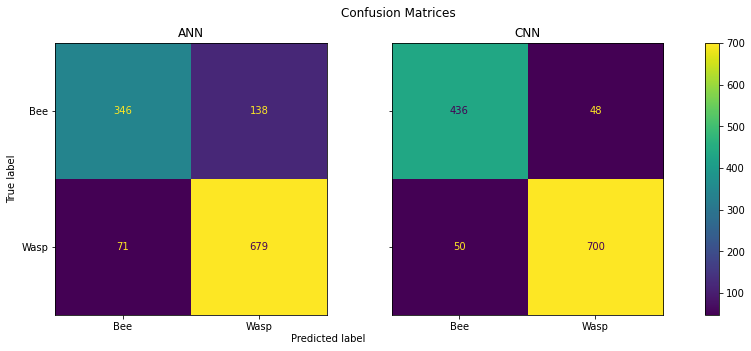

In [19]:
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(15, 5))
fig.suptitle('Confusion Matrices')

for i, cf_matrix in enumerate(cf_matrices):
  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["Bee", "Wasp"])

  disp.plot(ax=axes[i])
  disp.ax_.set_title(models[i][1])
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')

fig.text(0.4, 0.05, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.01, hspace=0.05)
fig.colorbar(disp.im_, ax=axes)
plt.show()

**Metrics Table**

In [8]:
metrics_table = PrettyTable(field_names=["Model", "Accuracy", "Loss", "F1 Score", "MCC"])
for i, model in enumerate(models):
  loss, accuracy = model[0].evaluate(valid, verbose=0)
  score = f1_score(true_values, pred_values[i], zero_division=1)
  mcc = matthews_corrcoef(true_values, pred_values[i])
  metrics_table.add_row([model[1], round(accuracy, 4), round(loss, 4), round(score, 4), round(mcc, 4)])

print(metrics_table)

+-------+----------+--------+----------+--------+
| Model | Accuracy |  Loss  | F1 Score |  MCC   |
+-------+----------+--------+----------+--------+
|  ANN  |  0.8306  | 0.6478 |  0.8666  | 0.6402 |
|  CNN  |  0.9206  | 0.3878 |  0.9346  | 0.8336 |
+-------+----------+--------+----------+--------+


In [9]:
HTML(metrics_table.get_html_string())

**ROC and AUC Curves**

In [10]:
fpr_ann, tpr_ann, thresholds_ann = roc_curve(true_values, pred_values_raw[0]) 
auc_ann = auc(fpr_ann, tpr_ann)

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(true_values, pred_values_raw[1]) 
auc_cnn = auc(fpr_cnn, tpr_cnn)


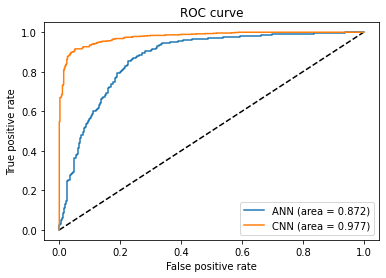

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ann, tpr_ann, label='ANN (area = {:.3f})'.format(auc_ann))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.4)
# plt.ylim(0.4, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_ann, tpr_ann, label='ANN (area = {:.3f})'.format(auc_ann))
# plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

**Final Test Evaluation CNN**

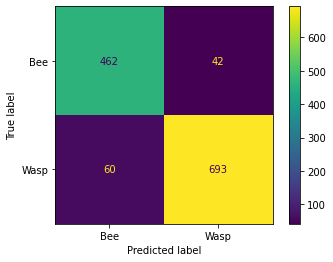

In [12]:
true_values = test.labels
true_values = np.array(true_values)

pred = models[1][0].predict(test)
pred_values_raw = pred
pred = (pred > 0.5).astype("int32")
pred = np.array(pred).ravel() #Flatten to turn [1] -> 1
cf_matrix = confusion_matrix(true_values, pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=["Bee", "Wasp"])
disp.plot()
plt.show()

In [13]:
metrics_table = PrettyTable(field_names=["Accuracy", "Loss", "F1 Score", "MCC"])
loss, accuracy = models[1][0].evaluate(test, verbose=0)
score = f1_score(true_values, pred, zero_division=1)
mcc = matthews_corrcoef(true_values, pred)
metrics_table.add_row([round(accuracy, 4), round(loss, 4), round(score, 4), round(mcc, 4)])

print(metrics_table)

+----------+--------+----------+--------+
| Accuracy |  Loss  | F1 Score |  MCC   |
+----------+--------+----------+--------+
|  0.9189  | 0.4146 |  0.9315  | 0.8324 |
+----------+--------+----------+--------+


In [14]:
HTML(metrics_table.get_html_string())

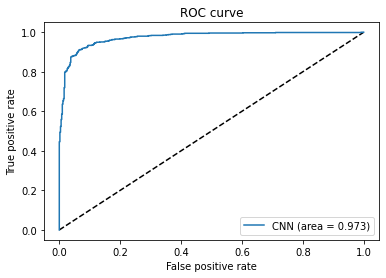

In [15]:
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(true_values, pred_values_raw) 
auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()